Leon Rode  
August 6, 2023

The following notebook implements canonical amplitude estimation (AE) as the final project for QIndia's Quantum Algorithms 101 course. The task was to implement AE from scratch to estimate the amplitude $\alpha_2$ of the following:

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
$$\ket{\psi}=\alpha_0\ket{00}+\alpha_1\ket{01}+\alpha_2\ket{10}+\alpha_3\ket{11}.$$

The algorithm and circuit used is adapted from the lecture "Quantum Algorithms" by Joran van Apeldoorn and Arjan Cornelissen.

In [203]:
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute
from qiskit.circuit.library import MCXGate, QFT
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np

Here we initialize $\ket{\psi}$ with two rotation gates, resulting in

$$U_{\text{init}}\ket{00}=\ket{\psi}=0.6932\ket{00}+0.0696\ket{01}+0.7138\ket{10}+0.0716\ket{11}.$$

For this problem we want to output $0.7138$ as closely as possible.

In [210]:
def u_init() -> QuantumCircuit:
    theta_0 = 0.2
    theta_1 = 1.6
    qc = QuantumCircuit(2)
    qc.ry(theta_0, 0)
    qc.ry(theta_1, 1)
    return qc

We define

$$U_{\text{label}}\ket{\psi}=\alpha_0\ket{G}\ket{1}+\alpha_1\ket{B}\ket{0},$$

introducing an ancilla qubit to help us identify our target state from the rest of the states. For this problem, we want to determine the amplitude of $\ket{10}$, so we let $\ket{G}=\ket{10}$ and use a multi-controlled bit flip to set the ancilla qubit to 1 if the state is 10.

We then let $$A=U_{\text{label}}U_{\text{init}}$$ and combine the circuits of the unitaries.

In [212]:
def a_unitary(basis: str) -> QuantumCircuit:
    qc = QuantumCircuit(3)
    qc = qc.compose(u_init(), [0, 1])
    qc.append(MCXGate(2, ctrl_state=basis), [0, 1, 2])
    return qc

Then we define the circuit for the inverse of $A$.

In [214]:
def generate_a_dagger(basis: str):
    a = a_unitary(basis)
    return a.inverse()

Note that $\ket{G}\ket{1}$ and $\ket{B}\ket{0}$ are orthogonal states. This means that they form a two-dimensional subspace as bases. The problem can now be approached geometrically using this fact.

The Grover operator $Q$ is defined as $$Q=AS_0A^{\dagger}S_{B0},$$ where $S_{B0}$ is the reflection of $\ket{\psi}$ over the vector $\ket{B}\ket{0}$, and $S_{0}$ is the reflection of $\psi$ over the all zero vector. We construct these unitary matrices below and combine them into one circuit.

In [215]:
def s_b0_unitary():
    # S_B0 = 2|B>|0><B|<0|-I = Z * I * I
    # Geometrically, this unitary changes theta to -theta, negating the 
    # amplitude in front of |G>|1>, which is produced by applying a Z gate.
    qc = QuantumCircuit(3)
    qc.z(2)
    return qc

In [216]:
# Construction of the full Q operator.

def q_unitary(basis: str) -> QuantumCircuit:
    q = QuantumCircuit(3)
    
    q = q.compose(s_b0_unitary(), [0, 1, 2])
    q = q.compose(generate_a_dagger(basis), [0, 1, 2])
    
    # S_0 = 2|000><000|-I
    unitary = [[1, 0, 0, 0, 0, 0, 0, 0], 
               [0, -1, 0, 0, 0, 0, 0, 0],
               [0, 0, -1, 0, 0, 0, 0, 0],
               [0, 0, 0, -1, 0, 0, 0, 0],
               [0, 0, 0, 0, -1, 0, 0, 0],
               [0, 0, 0, 0, 0, -1, 0, 0],
               [0, 0, 0, 0, 0, 0, -1, 0],
               [0, 0, 0, 0, 0, 0, 0, -1]]
    q.unitary(unitary, [0, 1, 2])
    
    q = q.compose(a_unitary(basis), [0, 1, 2])
    return q

In [217]:
def qft_dagger(qc, n):
    # Applies inverse QFT on the first n qubits
    for i in range(n):  
        for j in range(i):
            qc.cp(-np.pi/(2**(i-j)),n-j-1,n-i-1)
        qc.h(n-i-1)

Next we perform phase estimation (PE) on $Q$ using the starting state $\ket{\psi}$. This works even though $\ket{\psi}$ may not be an eigenvector of $Q$ because of linearity:

Let $\ket{\psi}$ be written as a superposition of $Q$'s eigenvectors $\ket{b_0}$ and $\ket{b_1}$:

$$\ket{\psi}=c_0\ket{b_0}+c_1\ket{b_1}.$$

Then

$$Q\ket{\psi}=c_0Q\ket{b_0}+c_1Q\ket{b_1}.$$
$$=c_0\left(e^{i2\pi\theta_0}\right)\ket{b_0}+c_1\left({e^{i2\pi\theta_1}}\right)\ket{b_1}.$$

Then by running PE we have either $\theta_0$ or $\theta_1$ written in the evaluation bits at random.

In [219]:
def amplitude_estimation(basis: str="10", eval_bits: int = 3) -> QuantumCircuit:
    num_qubits = eval_bits + 3 # + 3 for |psi>
    est = QuantumCircuit(eval_bits + 3, eval_bits) 
    est = est.compose(a_unitary(basis), range(num_qubits - 3, num_qubits))
    
    est.h(range(0, eval_bits))
    
    q_controlled = q_unitary(basis).to_gate().control()
    
    for i in range(eval_bits, 0, -1):
        for x in range(2 ** (i-1)):
            est.append(q_controlled, [i-1] + list(range(eval_bits, num_qubits)))
    qft_dagger(est, eval_bits)
    
    for i in range(eval_bits):
        est.measure(i, i)
    
    return est

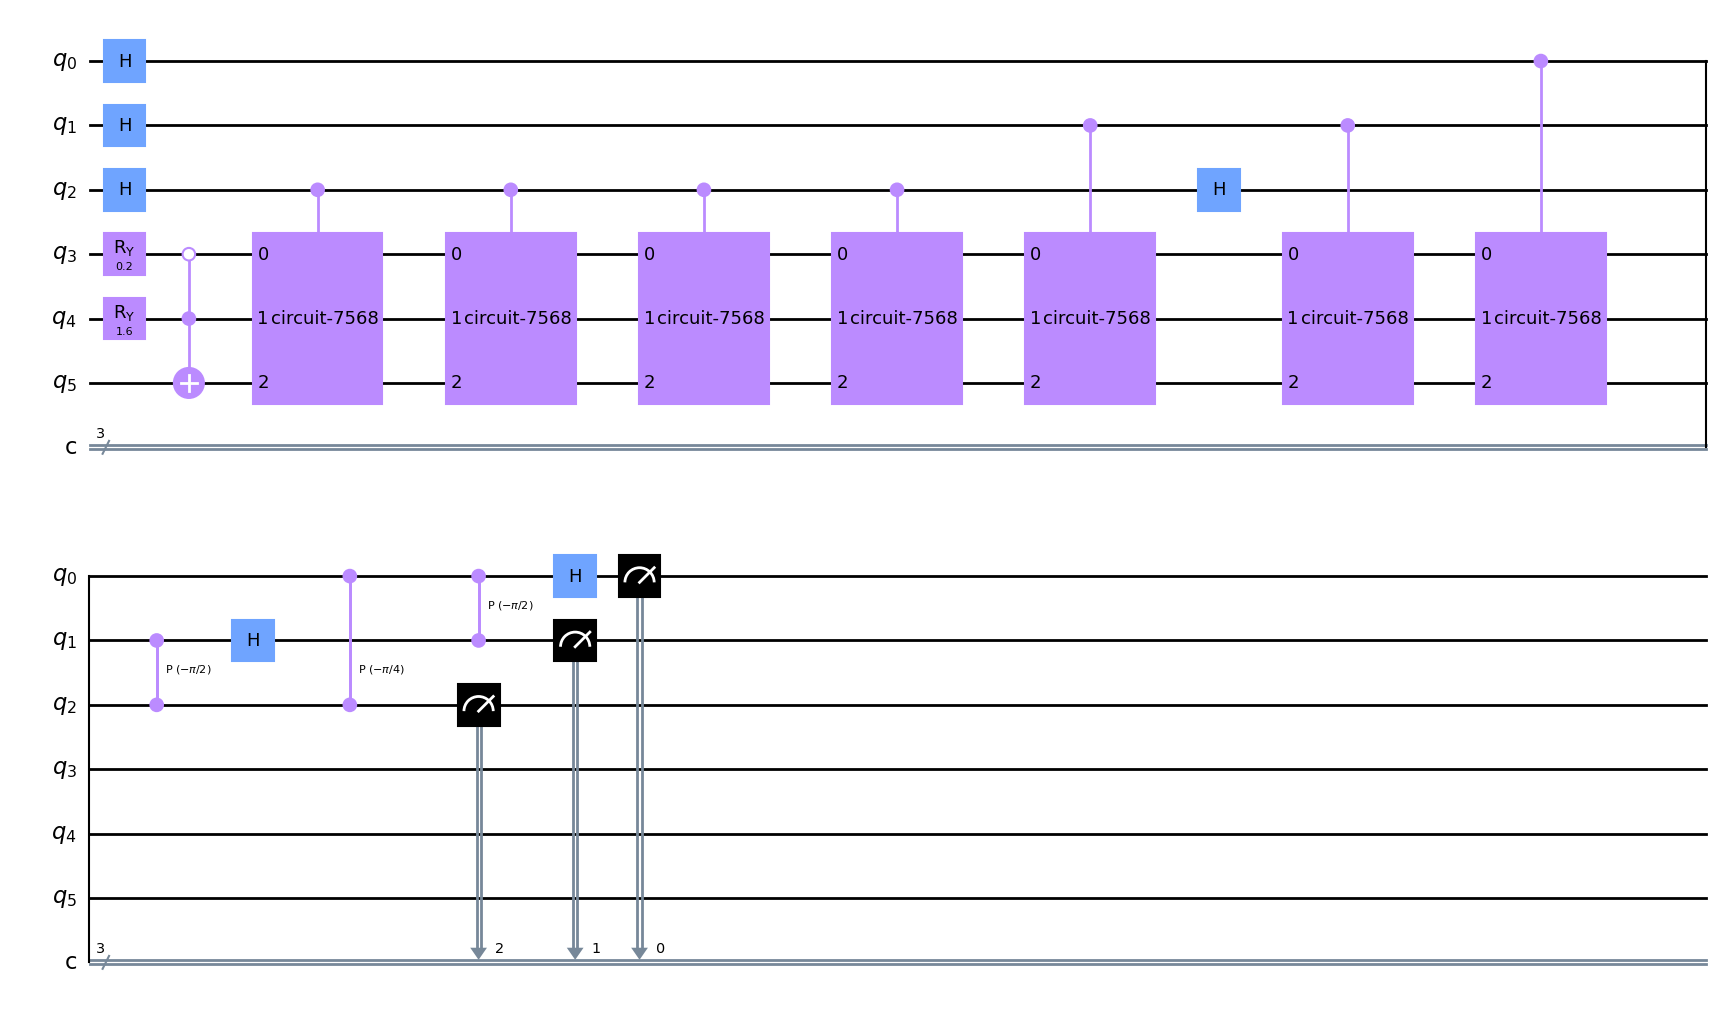

In [241]:
circuit = amplitude_estimation("10", 3)
circuit.draw()

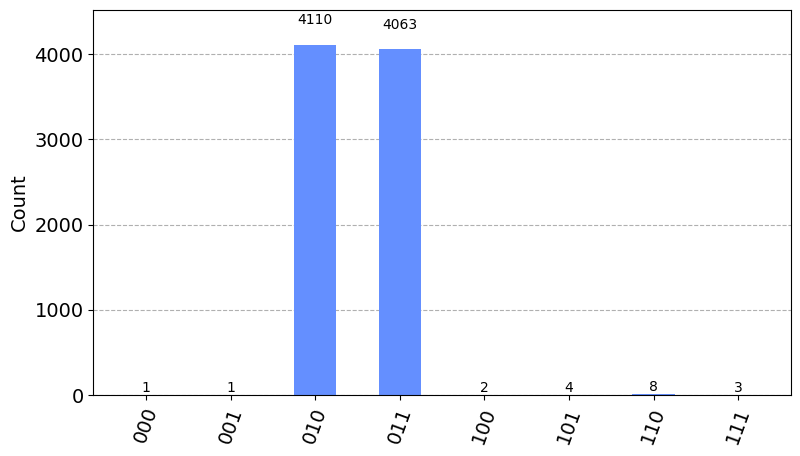

In [242]:
sim = Aer.get_backend("aer_simulator")
shots = 8192
counts = execute(circuit, sim, shots=shots).result().get_counts()
plot_histogram(counts, figsize=(9,5))

We see below that amplitude $\approx0.707$ appears as our output $>99$ percent of the time.

In [243]:
for key, value in counts.items():
    s = 0
    v = -1
    
    for c in key[::-1]: # key should be read right-to-left due to Qiskit's little endian notation
        s += int(c) * (2 ** (v))
        v -= 1
    print(f"Amplitude {np.sin(s * np.pi)} appeared with {100 * value/shots} probability.")

Amplitude 0.3826834323650898 appeared with 0.0244140625 probability.
Amplitude 0.9238795325112867 appeared with 0.048828125 probability.
Amplitude 0.9238795325112867 appeared with 0.09765625 probability.
Amplitude 1.0 appeared with 0.01220703125 probability.
Amplitude 0.3826834323650899 appeared with 0.03662109375 probability.
Amplitude 0.7071067811865476 appeared with 49.59716796875 probability.
Amplitude 0.0 appeared with 0.01220703125 probability.
Amplitude 0.7071067811865475 appeared with 50.1708984375 probability.
